In [51]:
import tensorflow as tf

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import random
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [52]:
### loading the pixel data

with np.load('cifar4-train.npz', allow_pickle=False) as data:
    cifar_data = dict(data.items())

X = cifar_data['pixels'].astype(np.float32)
y = cifar_data['labels']

## reshaping X to its original format
X = X.reshape(5000, 32, 32, 3)


In [53]:
X.shape

(5000, 32, 32, 3)

In [54]:
## rescaling btween -.5 and .5
X = (X-128)/255

In [55]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=1000, train_size = 4000, 
                                                      random_state=0, stratify = y)

X_tr_tr, X_tr_te, y_tr_tr, y_tr_te = train_test_split(X_tr, y_tr, test_size=800, train_size = 3200, 
                                                      random_state=0, stratify = y_tr)

In [56]:
print(X_tr.min(), X_tr.max())

-0.5019608 0.49803922


In [57]:
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [63]:
graph = tf.Graph()



with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    print('Input:', X.shape)

    # Convolutional layer
    conv = tf.layers.conv2d(
        X, # Input data
        filters= 64, # 64 filters
        kernel_size=(5, 5), # Kernel size: 5x5
        strides=(2, 2), # Stride: 2
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv' # Add name
    )
    
    print('Conv shape: ', conv.shape)
    
    # Max pooling layer
    pool = tf.layers.max_pooling2d(
        conv, # Convolution output
        pool_size=(2, 2), # Pool size: 2
        strides=(2, 2), # Stride: 2
        padding='SAME' # "same" padding
    )

    print('Pool shape: ', pool.shape)
    
    # Convolutional layer
    conv2 = tf.layers.conv2d(
        pool, # Max pooling output
        filters=64, # 16 filters
        kernel_size=(3, 3), # Kernel size: 3x3
        strides=(1, 1), # Stride: 1
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv2' # Add name
    )

    print('Conv2 shape :', conv2.shape)
    
    # Max pooling layer (2x2, stride: 2)
    pool2 = tf.layers.max_pooling2d(
        conv2, pool_size=(2, 2), strides=(2, 2), padding='SAME')

    print('Pool2 shape :', pool2.shape)
    
    # Flatten output
    flat_output = tf.reshape(pool2, [-1, 1024])
    print('Flatten:', flat_output.shape)
    
    # Dropout
    training = tf.placeholder(dtype=tf.bool)
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)
    
    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output, 256, # 256 hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer:', fc1.shape)
    
    # Output layer
    logits = tf.layers.dense(
        fc1, 4, # One output unit per category
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Output layer:', logits.shape)
    
        # Kernel of the 1st conv. layer
    with tf.variable_scope('conv', reuse=True):
           conv_kernels = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))


Input: (?, 32, 32, 3)
Conv shape:  (?, 16, 16, 64)
Pool shape:  (?, 8, 8, 64)
Conv2 shape : (?, 8, 8, 64)
Pool2 shape : (?, 4, 4, 64)
Flatten: (?, 1024)
Dropout: (?, 1024)
Fully-connected layer: (?, 256)
Output layer: (?, 4)


In [85]:
# Validation accuracy
valid_acc_values = []

start = timeit.default_timer()

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(60):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_tr_tr, y_tr_tr, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: True
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_tr_te,
            y: y_tr_te,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        clear_output()
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Evaluate test accuracy
    score_cnn = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
            training: False
    })
    print('Test accuracy: {:.3f}'.format(score_cnn))
    
stop = timeit.default_timer()
print('Result in {:.2f} minutes'.format((stop-start)/60))

Epoch 60 - valid: 0.793 train: 0.959 (mean)
Test accuracy: 0.809
Result in 3.41 minutes


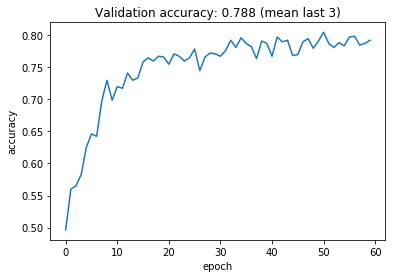

In [86]:
# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [87]:
print('Convolutional network accuracy (test set): ', score_cnn) 

Convolutional network accuracy (test set):  0.809


In [88]:
%store score_cnn

Stored 'score_cnn' (float32)


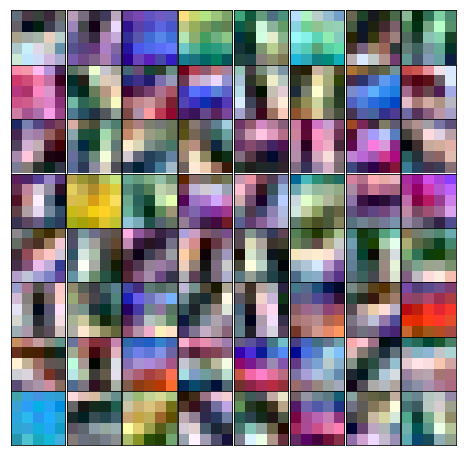

In [90]:
###  plot the trained weights of the kernels from the first convolutional layer.

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()

We got the blue sky/water. 